In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
import numpy as np
from keras import applications
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import numpy as np
import tensorflow as tf

from dlutils import plot_image_batch_w_labels
from common import util
%matplotlib nbagg

#from utils.image_history_buffer import ImageHistoryBuffer

In [4]:
def refiner_network(input_image_tensor,img_channels):
   
    def resnet_block(input_features, nb_features=64, nb_kernel_rows=3, nb_kernel_cols=3):
        """
        A ResNet block with two `nb_kernel_rows` x `nb_kernel_cols` convolutional layers,
        each with `nb_features` feature maps.

        See Figure 6 in https://arxiv.org/pdf/1612.07828v1.pdf.

        :param input_features: Input tensor to ResNet block.
        :return: Output tensor from ResNet block.
        """
        y = layers.Convolution2D(nb_features, nb_kernel_rows, nb_kernel_cols, border_mode='same')(input_features)
        y = layers.Activation('relu')(y)
        y = layers.Convolution2D(nb_features, nb_kernel_rows, nb_kernel_cols, border_mode='same')(y)

        y = layers.merge([input_features, y], mode='sum')
        return layers.Activation('relu')(y)

    x = layers.Convolution2D(64, 3, 3, border_mode='same', activation='relu')(input_image_tensor)

    # the output is passed through 4 ResNet blocks
    for _ in range(4):
        x = resnet_block(x)

    return layers.Convolution2D(img_channels, 1, 1, border_mode='same', activation='tanh')(x)

In [5]:
def setup_refiner(refiner_model_path,img_height=100,img_width =100,img_channels = 1):
    def self_regularization_loss(y_true, y_pred):
        delta = 0.0001  # FIXME: need to figure out an appropriate value for this
        return tf.multiply(delta, tf.reduce_sum(tf.abs(y_pred - y_true)))
    synthetic_image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
    refined_image_tensor = refiner_network(synthetic_image_tensor,img_channels)
    refined_or_real_image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
    refiner_model = models.Model(input=synthetic_image_tensor, output=refined_image_tensor, name='refiner')
    refiner_model.load_weights(refiner_model_path)
    sgd = optimizers.SGD(lr=0.001)
    refiner_model.compile(optimizer=sgd, loss=self_regularization_loss)
    return refiner_model

In [6]:
model  = setup_refiner("/home/drc/Chris/SimGAN/cache_saved/refiner_model_step_9000.h5")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concate

In [7]:
path = "/media/drc/DATA1/chris_labelfusion/logs_test/2017-06-16-15/images/"

In [10]:
d,c,s,r,n,g = util.get_images(2,10,path)

## The Data we have

<IPython.core.display.Javascript object>


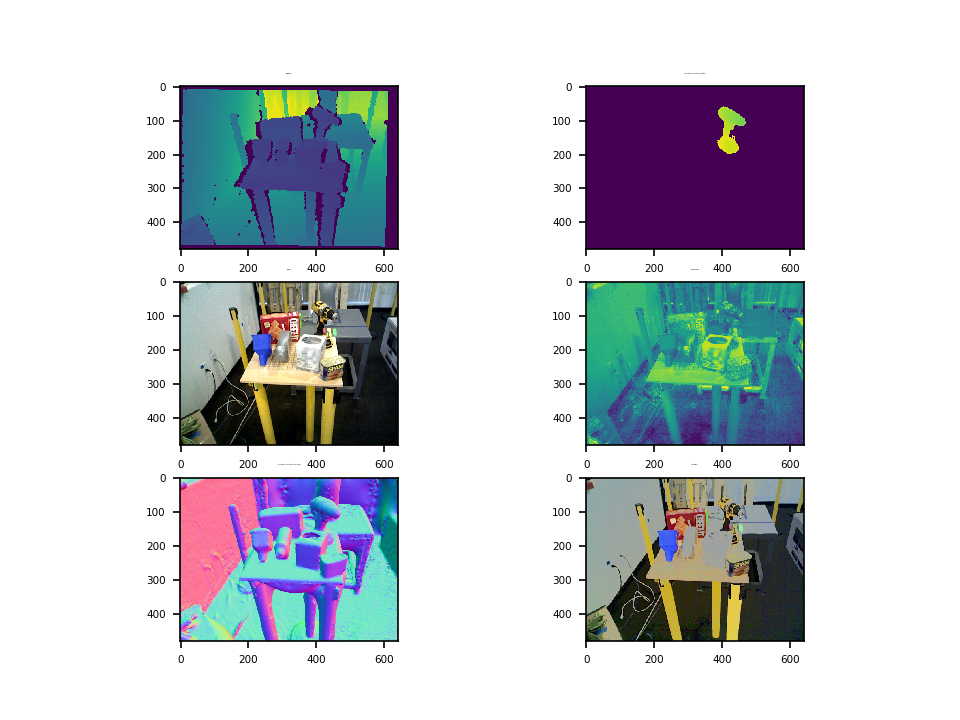

In [11]:
plt.rcParams.update({'font.size': 5})
fig = plt.figure()
a=fig.add_subplot(3,2,1)
imgplot = plt.imshow(d)
a.set_title('Depth')
a=fig.add_subplot(3,2,3)
imgplot = plt.imshow(c)
a.set_title('RGB')
a=fig.add_subplot(3,2,6)
imgplot = plt.imshow(r)
a.set_title('Albedo')
a=fig.add_subplot(3,2,4)
imgplot = plt.imshow(s)
a.set_title('Shading')
a=fig.add_subplot(3,2,2)
imgplot = plt.imshow(g)
a.set_title('Ground Truth Depth')
a=fig.add_subplot(3,2,5)
imgplot = plt.imshow(n)
a.set_title('Ground Truth Normal')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


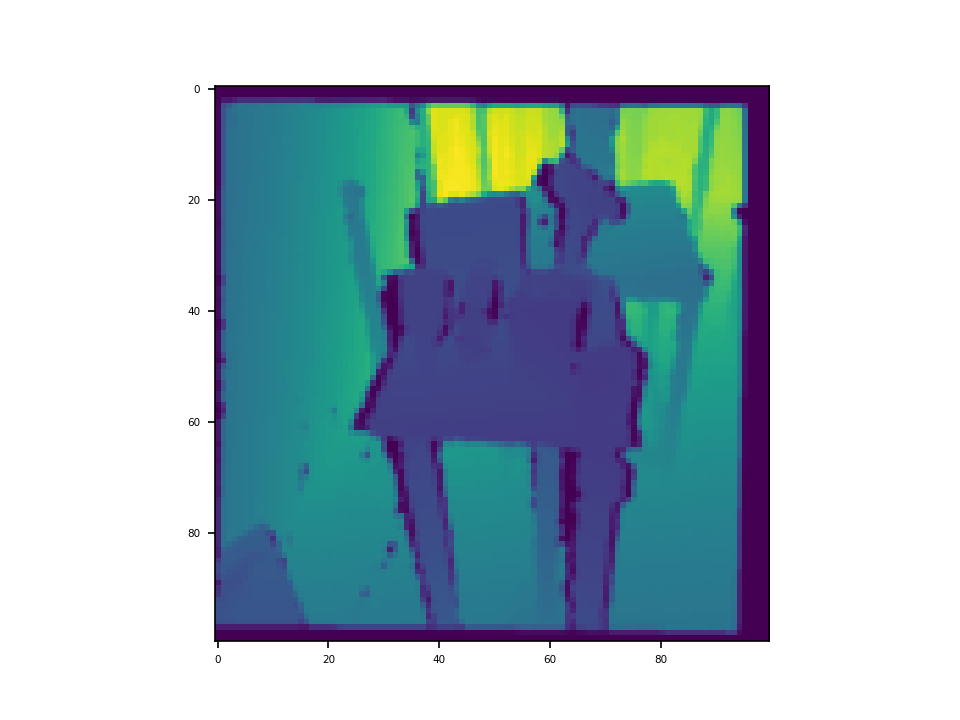

In [188]:
imgplot = plt.imshow(misc.imresize(d,(100,100)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


<IPython.core.display.Javascript object>


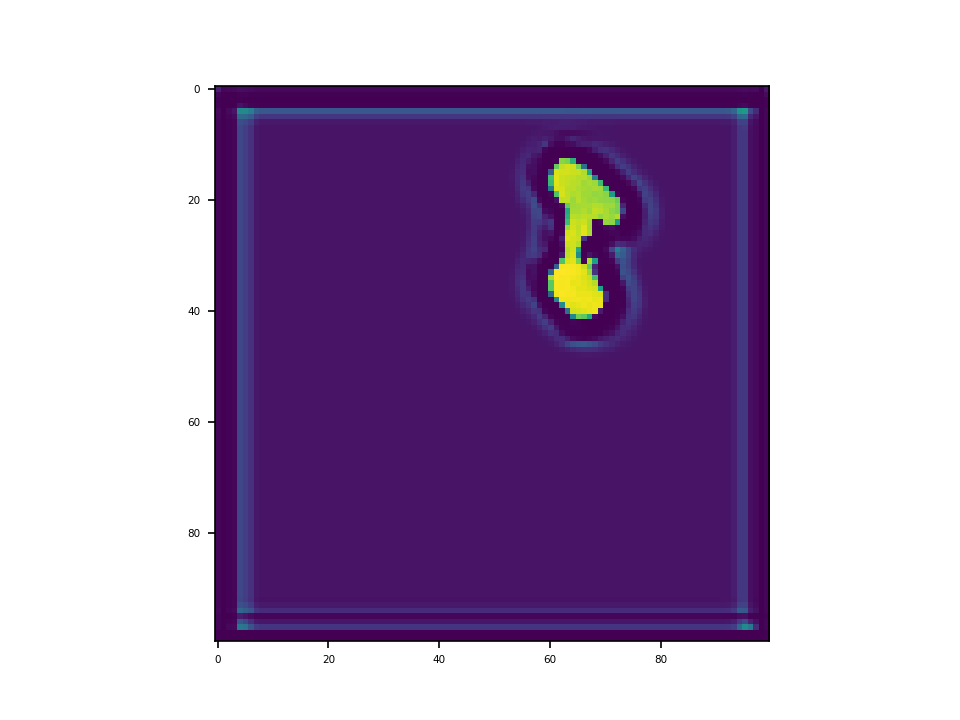

In [32]:
g_resize = misc.imresize(g,(100,100))
imgplot = plt.imshow(misc.imresize(g_resize,(100,100)))

In [33]:
g_resize=g_resize/float(np.max(g_resize))*2-1

In [34]:
sim_gan_low_dim = np.reshape((model.predict(x=np.reshape(g_resize,(1,100,100,1)))),(100,100))
plt.imshow(sim_gan_low_dim)

<IPython.core.display.Javascript object>


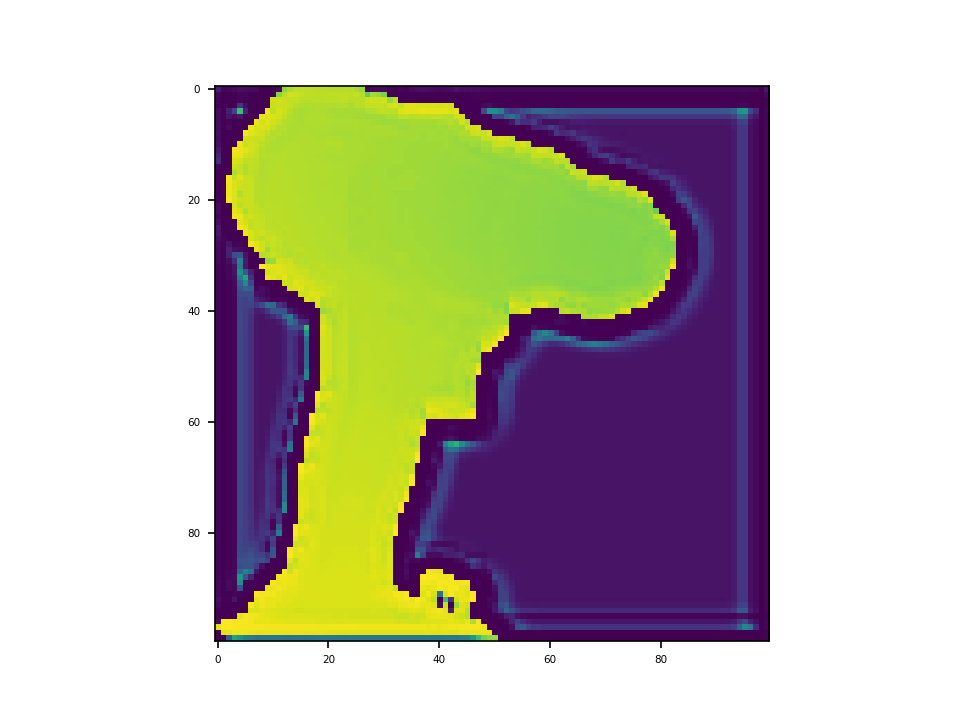

In [41]:
drill = np.reshape((model.predict(x=np.reshape(imm,(1,100,100,1)))),(100,100))
plt.imshow(drill)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


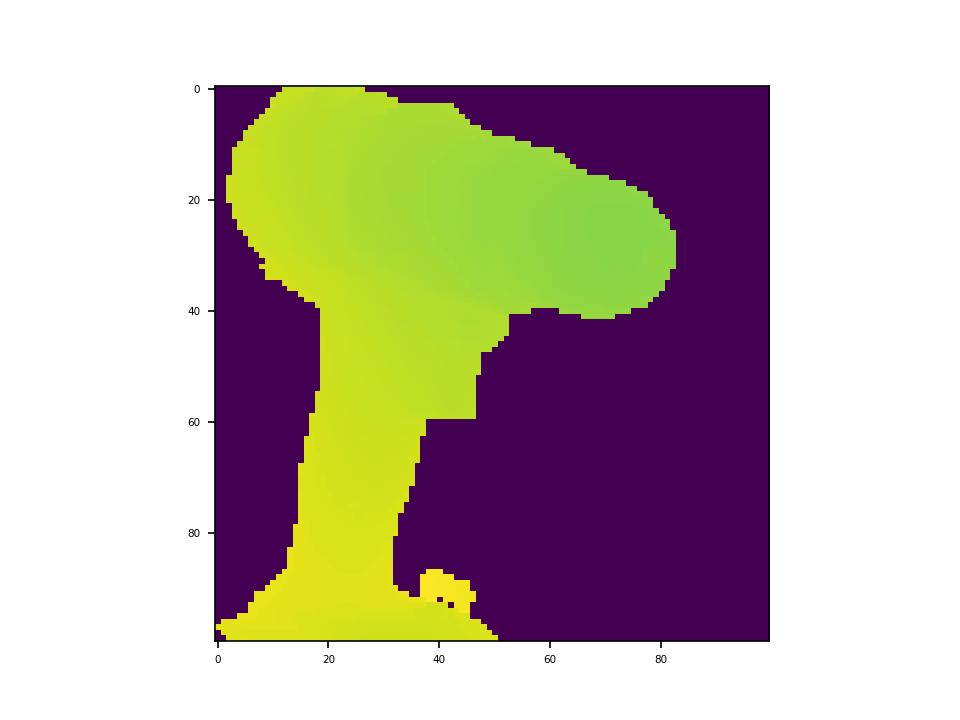

In [40]:
imm =misc.imread("/media/drc/DATA1/chris_labelfusion/CORL2017/drill/0000003000depth_ground_truth.png")
x_low,x_high,y_low,y_high = bounding_box(imm,size =100)
imm=imm.astype(np.float)
imm=imm/np.max(imm)*2-1
imm[imm==0]=np.NaN
imm = imm[x_low:x_high,y_low:y_high]
plt.imshow(imm)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


<IPython.core.display.Javascript object>


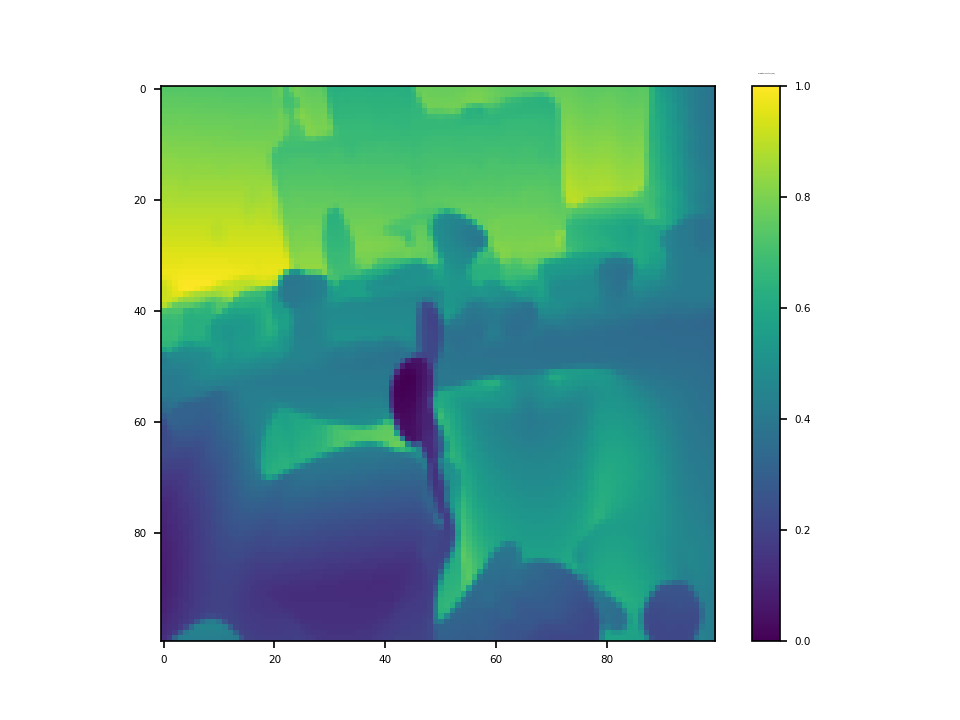

Text(0.5,1,u'Depth delta (m)')

In [86]:
im2 =misc.imread("/media/drc/DATA1/chris_labelfusion/CORL2017/logs_test/2017-06-13-08/images/0000000378depth_ground_truth.png", mode="I",flatten=True)
im2_resize = misc.imresize(im2,(100,100))
im2_resize = im2_resize/float(np.max(im2_resize))
plt.imshow(im2_resize)
clb = plt.colorbar()
clb.ax.set_title('Depth delta (m)')

In [74]:
im2_d+=(0-np.min(im2_d))
im2_d = im2_d/float(np.max(im2_d))

<IPython.core.display.Javascript object>


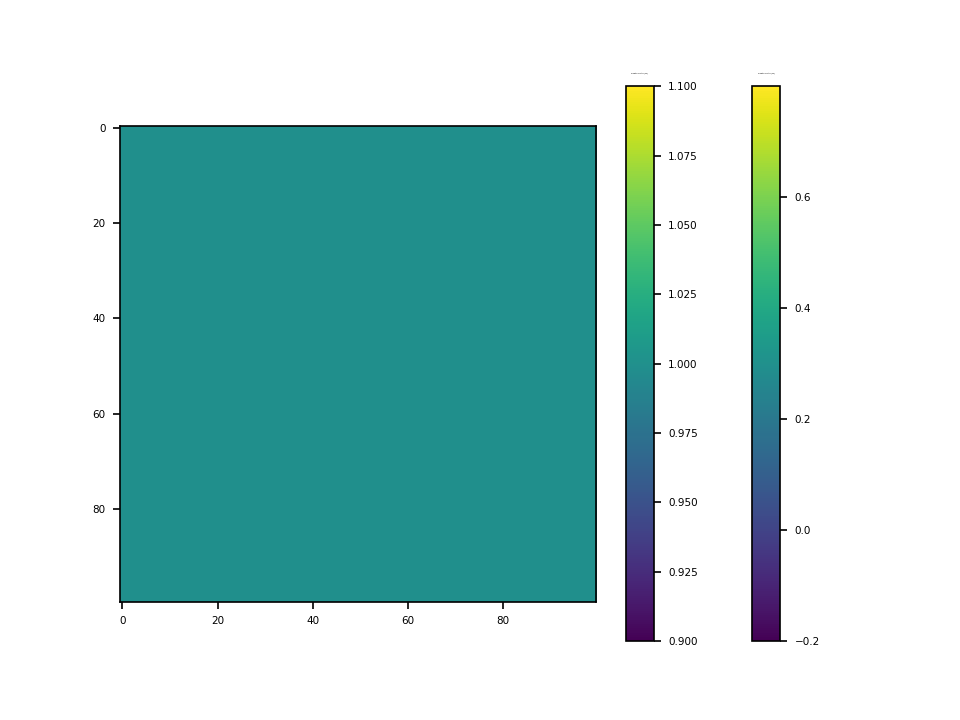

Text(0.5,1,u'Depth delta (m)')

In [76]:
imgplot = plt.imshow(im2_d)
clb = plt.colorbar()
clb.ax.set_title('Depth delta (m)')

<IPython.core.display.Javascript object>


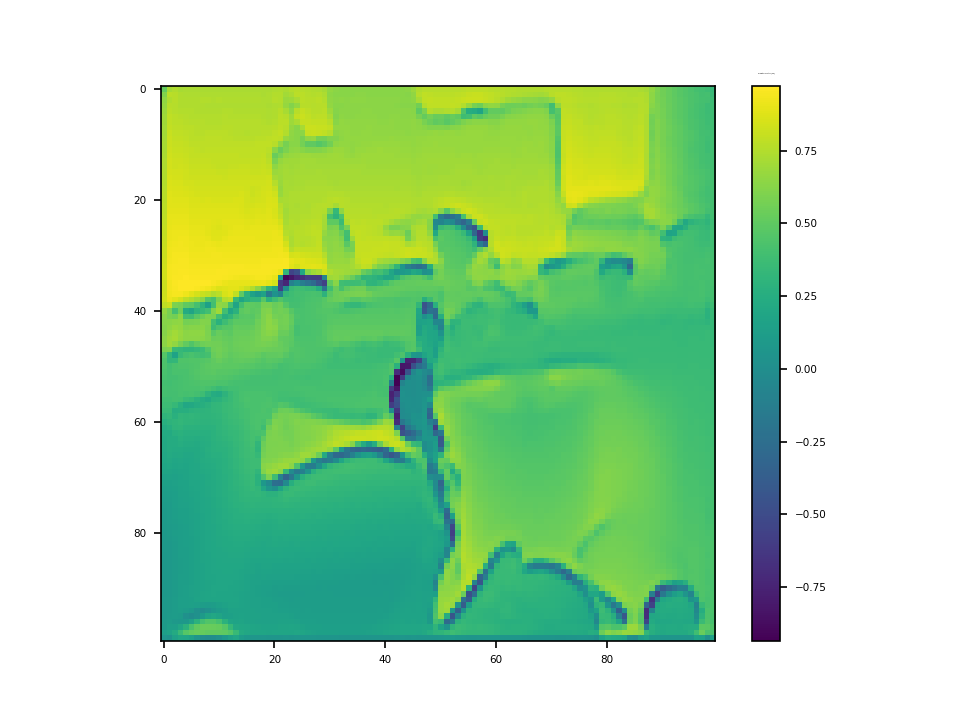

Text(0.5,1,u'Depth delta (m)')

In [87]:
im2_d = np.reshape((model.predict_on_batch(x=np.reshape(im2_resize,(1,100,100,1)))),(100,100))
imgplot = plt.imshow(im2_d)
clb = plt.colorbar()
clb.ax.set_title('Depth delta (m)')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


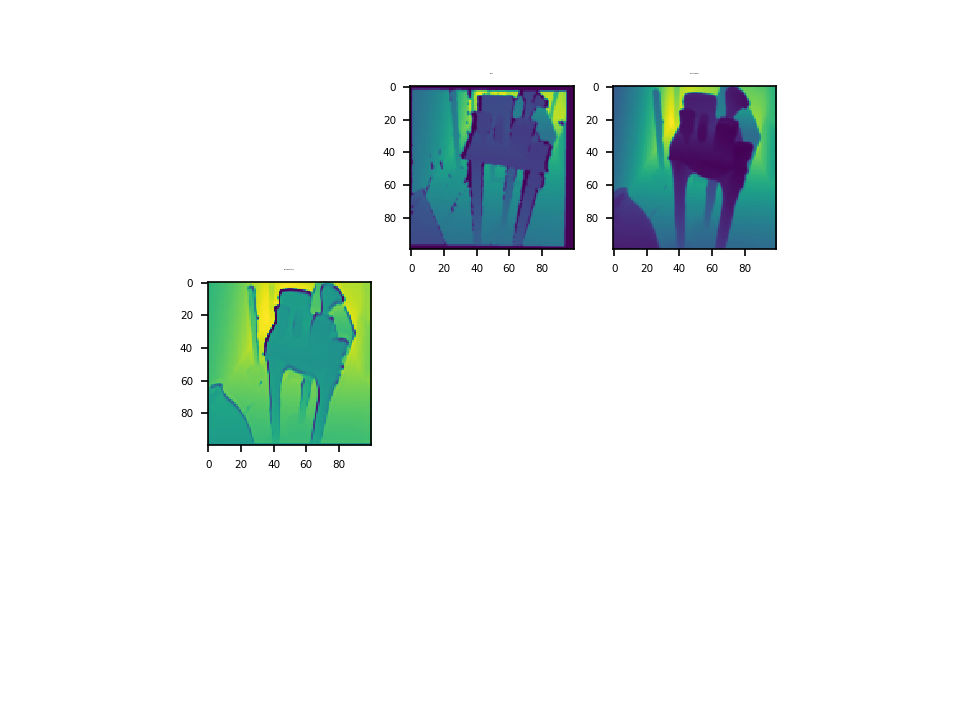

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Text(0.5,1,u'synthetic')

In [93]:
g_resize = misc.imresize(g,(100,100))
g_resize = g_resize/float(np.max(g_resize))
g_d = np.reshape((model.predict(x=np.reshape(g_resize,(1,100,100,1)))),(100,100))
fig = plt.figure()
a=fig.add_subplot(3,1,1)
imgplot = plt.imshow(misc.imresize(d,(100,100)))
a.set_title('real')
a=fig.add_subplot(3,2,3)
imgplot = plt.imshow(g_d)
a.set_title('generated')
a=fig.add_subplot(3,2,2)
imgplot = plt.imshow(g_resize)
a.set_title('synthetic')

In [ ]:
plt.imshow(d-g)
clb = plt.colorbar()
clb.ax.set_title('Depth delta (m)')

In [ ]:
from scipy import ndimage as ndi
from skimage import filter
from skimage import color
from skimage import io
rg = color.rgb2gray(r)
rg = ndi.gaussian_filter(rg,4)
edges1 = filter.canny(rg)
edges2 = filter.canny(rg,sigma =6)
plt.imshow(edges1)
plt.imshow(edges2+d*.001)

# other data to try
    
    can we get raw ir image?
    derivative of ground truth depth RGB, sharp discontinuites not captured by normal angle

## Where do the depth values differ

In [12]:
d1= np.copy(d)
gt1 =np.copy(g)
mask = create_depth_mask(gt1,0,1300)
d1[~mask]=0
gt1[~mask]=0
plt.imshow(d1-gt1)

<IPython.core.display.Javascript object>


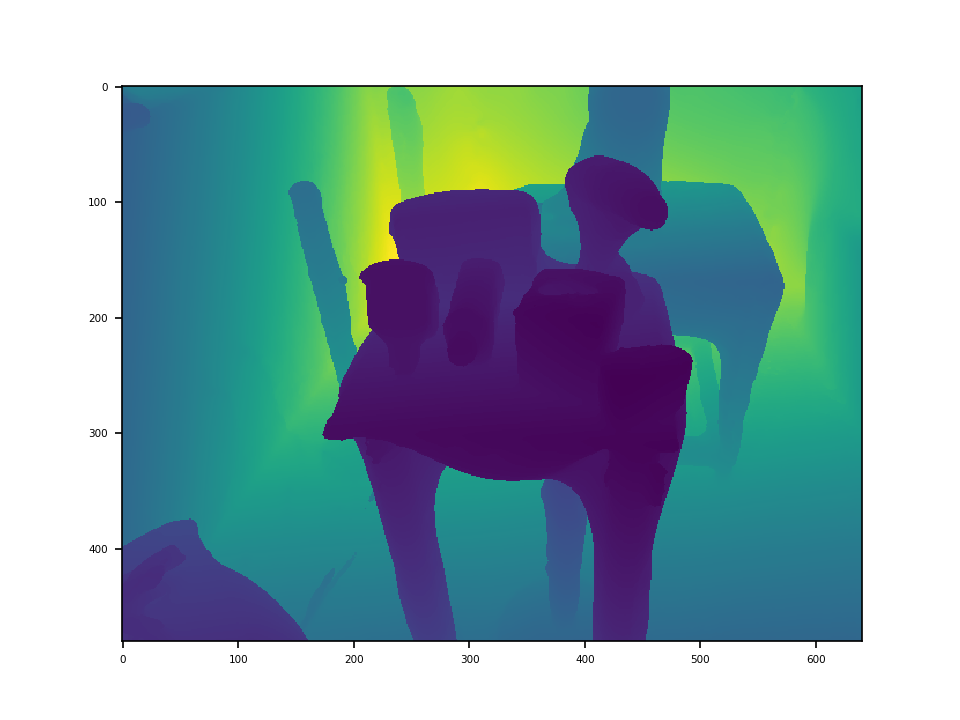

In [84]:
#c[~mask]=0
plt.imshow(g)

## Lets try predicting binary depth return given intrinsic intensities

<IPython.core.display.Javascript object>


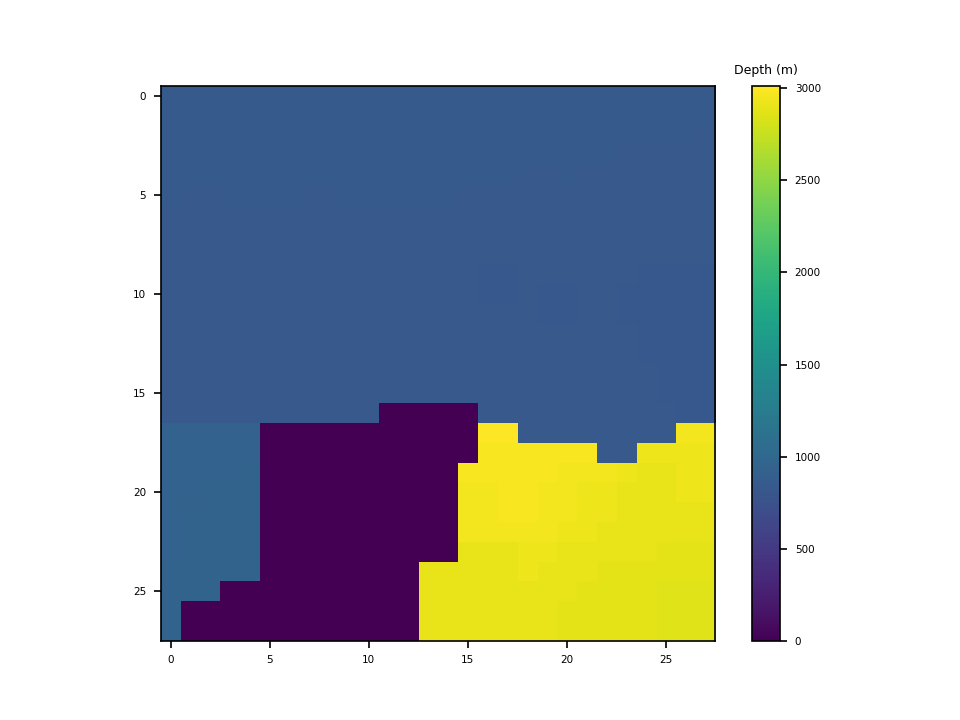

In [15]:
from matplotlib import cm
plt.imshow(d[250:278,250:278])
clb = plt.colorbar()
clb.ax.set_title('Depth (m)')
 
plt.show()

In [23]:
def test(path,start=1,end=10,bounds=[100,400,100,500],file_digits=10):
    x = []
    num_pos=0
    for i in range(start,end+1):
        d,n,gt = get_images_short(i,file_digits,path)
        pos = np.argwhere(d[bounds[0]:bounds[1],bounds[2]:bounds[3]]==0)   
        data = map(lambda x: n[x[0],x[1]],pos)
        x.extend(data)        
    return np.array(x)
x=test(path,1,2)

In [153]:
def calc_PRF(tp,fp,fn):
    P = tp/float(tp+fp)
    R= tp/float(tp+fn)
    if tp ==0:
        return P,R,0
    return (P,R,2.*P*R/(P+R))

In [53]:
[0, 0] in np.argwhere(np.zeros((2,2))%2==0)

True

In [212]:
zeros = np.argwhere(d[50:400,20:500]==0)
zeros

array([[  0, 411],
       [  0, 412],
       [  0, 413],
       ..., 
       [349, 436],
       [349, 437],
       [349, 438]])

In [213]:
non_zeros = np.argwhere(d[50:400,20:500]!=0)
non_zeros

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ..., 
       [349, 477],
       [349, 478],
       [349, 479]])

In [223]:
norm[non_zeros[:,0],non_zeros[:,1]]

array([  59.85286973,   58.02597186,   59.85286973, ...,  115.00607415,
        116.0685625 ,  116.0685625 ])

In [226]:
norm = angle_from_normal(convert_rgb_normal(n[50:400,20:500]))
norm[-1][-1]

116.0685624984061

In [ ]:
z = np.take(norm,zeros)[:,0]

In [ ]:
z1 = np.take(norm,non_zeros)[:,0]

<IPython.core.display.Javascript object>


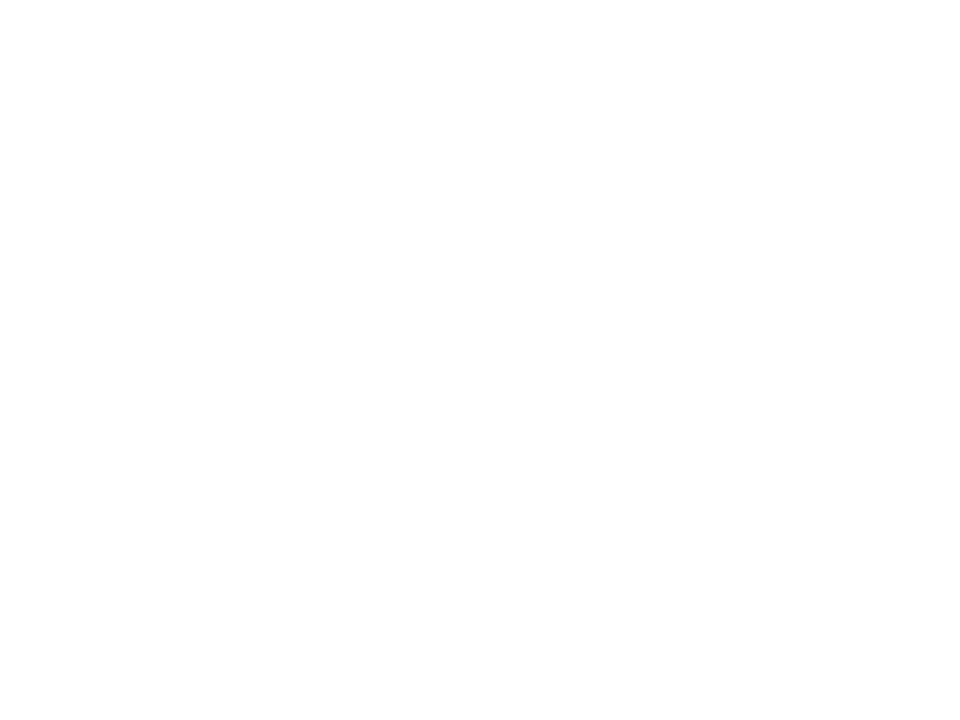

In [34]:
def plot_hist(path,num_params=50,start=2,end=3000,file_digits=10):
        params = np.linspace(0,1,num_params)
        data = dict.fromkeys(params,0)
        data_tot = dict.fromkeys(params,0)
        len1=0
        len2=0
        for i in range(start,end+1):
            d,n,gt = get_images_short(i,file_digits,path)
            d= d[50:400,20:500]
            n = n[50:400,20:500]
            gt = gt[50:400,20:500]
            norm = ratio_from_normal(convert_rgb_normal(n))
            zeros = np.argwhere(d==0)
            len1+=len(zeros)
            zeros = np.array(filter(lambda x: gt[x[0],x[1]]<1200,zeros))
            len2+=len(zeros)
            z = norm[zeros[:,0],zeros[:,1]]
            h,w  = np.shape(norm)
            for i in range(h):
                for j in range(w):
                    if gt[i,j]<1200:
                        data_tot[params[(np.abs(params-norm[i,j])).argmin()]]+=1
            for i in z:
                data[params[(np.abs(params-i)).argmin()]]+=1
        vals= []
        for key in data.keys():
            vals.append(data[key]/float(data_tot[key]))
        plt.bar(data.keys(),vals,width=.01)
        return data,data_tot,len1,len2
a = plot_hist(path)

<IPython.core.display.Javascript object>


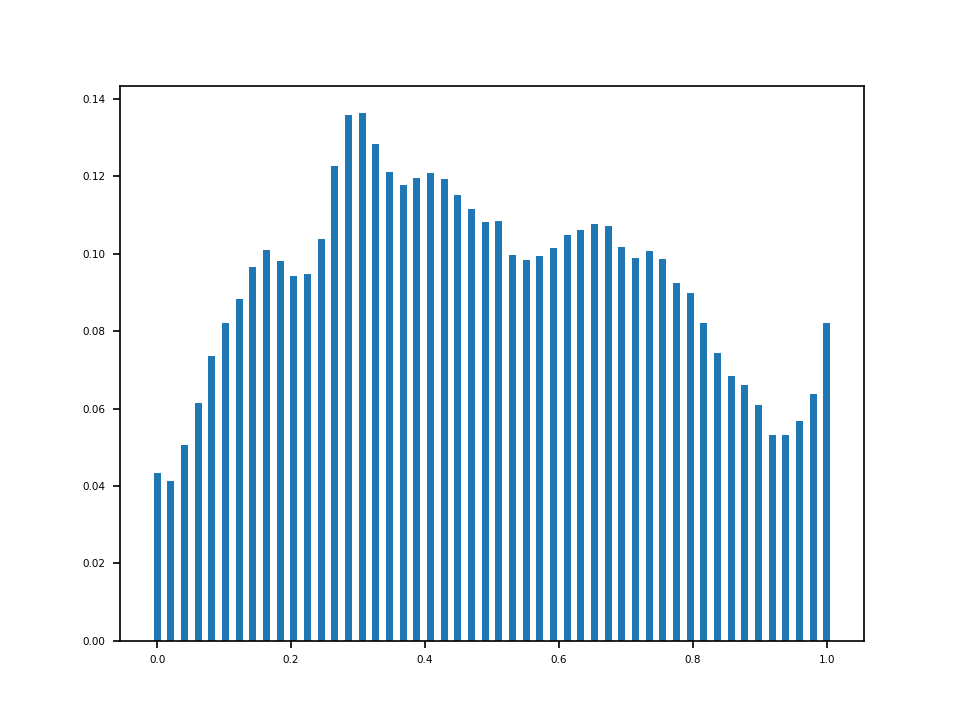

<Container object of 50 artists>

In [79]:
vals=[]
for key in a[0].keys():
        vals.append(a[0][key]/float(a[1][key]))
plt.bar(a[0].keys(),vals,width=.01)

In [227]:
def param_search(path,params,start=1,end=10,file_digits=10):
    param_scores = {}
    for p in params:
        print "param "+str(p)
        tp = 0
        fn = 0
        fp = 0
        for i in range(start,end+1):
            d,n,gt = get_images_short(i,file_digits,path)
            h,w = np.shape(d)
            d= d[50:400,20:500]
            n = n[50:400,20:500]
            gt = gt[50:400,20:500]
            norm = angle_from_normal(convert_rgb_normal(n))
            zeros = np.argwhere(d==0)
            non_zeros = np.argwhere(d!=0)
            z = norm[zeros[:,0],zeros[:,1]]
            z1 = norm[non_zeros[:,0],non_zeros[:,1]]
            true_pos = np.sum(z<p)
            f_pos = len(z)-true_pos
            tp += true_pos
            fn +=f_pos
            fp += np.sum(z1<p)
        print(tp,fn,fp)
        param_scores[round(np.nan_to_num(calc_PRF(tp,fp,fn))[0],5)] = p
    k = np.max(np.nan_to_num(param_scores.keys()))
    print np.nan_to_num(param_scores.keys())
    return param_scores[k],k
        

In [229]:
param_search(path,params=range(40,180))

param 40
(1914, 128832, 54343)
param 41
(2137, 128609, 59586)
param 42
(2137, 128609, 59586)
param 43
(2137, 128609, 59586)
param 44
(2375, 128371, 64957)
param 45
(2375, 128371, 64957)
param 46
(2672, 128074, 70383)
param 47
(2672, 128074, 70383)
param 48
(2960, 127786, 75455)
param 49
(2960, 127786, 75455)
param 50
(2960, 127786, 75455)
param 51
(3278, 127468, 80365)
param 52
(3278, 127468, 80365)
param 53
(3658, 127088, 85766)
param 54
(3658, 127088, 85766)
param 55
(4055, 126691, 91933)
param 56
(4055, 126691, 91933)
param 57
(4488, 126258, 98010)
param 58
(4488, 126258, 98010)
param 59
(5029, 125717, 105141)
param 60
(5502, 125244, 112831)
param 61
(5502, 125244, 112831)
param 62
(5984, 124762, 121017)
param 63
(5984, 124762, 121017)
param 64
(6538, 124208, 131018)
param 65
(6538, 124208, 131018)
param 66
(7081, 123665, 142791)
param 67
(7750, 122996, 156722)
param 68
(7750, 122996, 156722)
param 69
(8384, 122362, 172232)
param 70
(9032, 121714, 190096)
param 71
(9032, 121714, 190

(179, 0.99221000000000004)

In [42]:
def labeled_data_normals(path,start=1,end=10,file_digits=10,shuffle= True):
    x = []
    y = []
    num_pos=0
    for i in range(start,end+1):
        d,n,gt = get_images_short(i,file_digits,path)
        n = cre
        mask = create_depth_mask(gt,0,1000)
        d[~mask]=-1
        pos = np.argwhere(d==0)
        neg = np.argwhere(d!=0)[:len(pos)]
        
        data = map(lambda x: np.arccos(n[x[0],x[1]][2]),pos)
        x.extend(data)
        num_pos+=len(data)
        y.extend(np.ones(len(data)))
        
        data1 = map(lambda x: np.arccos(n[x[0],x[1]][2]),neg)
        x.extend(data1)
        y.extend(np.zeros(len(data1)))
        
    x,y = np.array(x),np.array(y)
    if shuffle:
        choices = np.random.choice(np.arange(len(x)),len(x)/100)  
        x,y = x[choices],y[choices]
    return x,y,num_pos

x,y,num = labeled_data_normals(path,1,200)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arccos


In [44]:
(x!=np.nan).any()

True

In [25]:
from sklearn import svm
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
clf = svm.SVC()
clf.fit(x, y)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
x_test,y_test,num_pos = labeled_data_normals(path,200,300)

In [27]:
clf.score(X=x_test,y=y_test)

0.77960671674768012

In [264]:
def labeled_data(path,start=1,end=10,bounds=[100,400,100,500],file_digits=10):
    x = []
    y = []
    num_pos=0
    for i in range(start,end+1):
        d,c,s,r = get_images(i,file_digits,path)
        pos = np.argwhere(d[bounds[0]:bounds[1],bounds[2]:bounds[3]]==0)
        neg = np.argwhere(d[bounds[0]:bounds[1],bounds[2]:bounds[3]]!=0)[:len(pos)]
        
        data = map(lambda x: [s[x[0],x[1]]],pos)
        x.extend(data)
        num_pos+=len(data)
        y.extend([1]*len(data))
        
        data1 = map(lambda x: [s[x[0],x[1]]],neg)
        x.extend(data1)
        y.extend([0]*len(data1))  
    return x,y,num_pos

x,y,num_pos=labeled_data(path,1,2)

ValueError: too many values to unpack

In [12]:
def labeled_data(path,start=1,end=10,bounds=[100,400,100,500],file_digits=10):
    x = []
    y = []
    num_pos=0
    for i in range(start,end+1):
        d,c,s,r = get_images(i,file_digits,path)
        pos = np.argwhere(d[bounds[0]:bounds[1],bounds[2]:bounds[3]]==0)
        neg = np.argwhere(d[bounds[0]:bounds[1],bounds[2]:bounds[3]]!=0)
        data = zip(r[pos][0][0],np.mean(s[pos][0][0],axis=1))
        x.extend(data)
        num_pos+=len(data)
        y.extend([1]*len(data))
        data1 = zip(r[neg][0][0],np.mean(s[neg][0][0],axis=1))
        x.extend(data1)
        y.extend([0]*len(data1))     
    return x,y,num_pos

x,y,num_pos=labeled_data(path,1)
len(x),len(y)

(12800, 12800)

In [13]:
def inspect(path,num_images=10,bounds=[100,400,100,500],file_digits=10):
    reflect = []
    shade = []
    for i in range(1,num_images+1):
        d,c,s,r = get_images(i,file_digits,path)
        index = np.argwhere(d[bounds[0]:bounds[1],bounds[2]:bounds[3]]==0)
        print r[index][0][0]
        reflect.append(r[index][0][0])
        shade.append(s[index][0][0])
    return reflect,shade

reflect,shade = inspect(path,2)

np.mean(reflect),np.mean(shade),np.std(reflect),np.std(shade)

[ 0.53333336  0.53333336  0.60784316  0.56862748  0.59215689  0.56862748
  0.65882355  0.55686277  0.40784314  0.59607846  0.5411765   0.49019608
  0.63921571  0.58431375  0.56862748  0.5411765   0.51372552  0.51372552
  0.51764709  0.51764709  0.52549022  0.53725493  0.50980395  0.56470591
  0.56078434  0.52549022  0.5529412   0.56078434  0.5411765   0.53333336
  0.53333336  0.55686277  0.55686277  0.57647061  0.57647061  0.60000002
  0.63921571  0.62352943  0.61960787  0.61960787  0.627451    0.62352943
  0.60392159  0.66274512  0.65490198  0.63921571  0.62352943  0.65882355
  0.62352943  0.66274512  0.66666669  0.64313728  0.64705884  0.63529414
  0.627451    0.63529414  0.627451    0.65098041  0.60000002  0.59607846
  0.58039218  0.68627453  0.69803923  0.7019608   0.71372551  0.63137257
  0.627451    0.61176473  0.63137257  0.63529414  0.63529414  0.65098041
  0.65098041  0.67450982  0.7019608   0.66274512  0.60392159  0.57254905
  0.5529412   0.57254905  0.54509807  0.59607846  0

(0.60149515, 0.54788196, 0.088457644, 0.14498085)

In [16]:
from sklearn import svm
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
clf = svm.SVC()
clf.fit(x, y)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
x_test,y_test,num_pos = labeled_data(path,3,4)

In [18]:
clf.score(X=x_test,y=y_test)

0.5554059485530547

In [53]:
clf.predict(X=[[.4]])

array([0])

In [15]:
count1=0
count2=0
for i in range(len(x)):
    if x[i]>.8:
        if y[i]==1: count1+=1
        else: count2+=1
count1/float(count2)

1.0

In [13]:
len(x),len(y)

(47450, 47450)